<a href="https://colab.research.google.com/github/Farshad127/Machine-Vision/blob/main/Tensorflow_Keras_With_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models


import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Function for reading the batch files
def load_cifar10_batch(file_path):
    with open(file_path, 'rb') as file:
        batch = pickle.load(file, encoding='bytes')
    return batch

In [3]:
# Specify the paths to the CIFAR-10 dataset batches
file_paths = [
    '/content/drive/MyDrive/Colab Notebooks/cifar-10-batches-py/data_batch_1',
    '/content/drive/MyDrive/Colab Notebooks/cifar-10-batches-py/data_batch_2',
    '/content/drive/MyDrive/Colab Notebooks/cifar-10-batches-py/data_batch_3',
    '/content/drive/MyDrive/Colab Notebooks/cifar-10-batches-py/data_batch_4',
    '/content/drive/MyDrive/Colab Notebooks/cifar-10-batches-py/data_batch_5'
]


# Load and concatenate the CIFAR-10 batches
images = []
labels = []

for file_path in file_paths:
    cifar_batch = load_cifar10_batch(file_path)
    images.append(cifar_batch[b'data'])
    labels.extend(cifar_batch[b'labels'])


# Concatenate the batches into a single training dataset
x_train = np.concatenate(images, axis=0)
y_train = np.array(labels)

print(np.shape(x_train))
print(np.shape(y_train))
x_train

(50000, 3072)
(50000,)


array([[ 59,  43,  50, ..., 140,  84,  72],
       [154, 126, 105, ..., 139, 142, 144],
       [255, 253, 253, ...,  83,  83,  84],
       ...,
       [ 35,  40,  42, ...,  77,  66,  50],
       [189, 186, 185, ..., 169, 171, 171],
       [229, 236, 234, ..., 173, 162, 161]], dtype=uint8)

In [4]:
# Load the CIFAR-10 test_batch

test_cifar_batch = load_cifar10_batch('/content/drive/MyDrive/Colab Notebooks/cifar-10-batches-py/test_batch')

test_images = []
test_labels =[]
test_images.append(test_cifar_batch[b'data'])
test_labels.extend(test_cifar_batch[b'labels'])

# Concatenate x_test

x_test = np.concatenate (test_images, axis=0)
y_test = test_labels

print(np.shape(x_test))
print(np.shape(y_test))
x_test


(10000, 3072)
(10000,)


array([[158, 159, 165, ..., 124, 129, 110],
       [235, 231, 232, ..., 178, 191, 199],
       [158, 158, 139, ...,   8,   3,   7],
       ...,
       [ 20,  19,  15, ...,  50,  53,  47],
       [ 25,  15,  23, ...,  80,  81,  80],
       [ 73,  98,  99, ...,  94,  58,  26]], dtype=uint8)

In [5]:
# Reshape the input data
x_train = np.reshape(x_train, (-1, 32, 32, 3))
x_test = np.reshape(x_test, (-1, 32, 32, 3))


print('x_train')
print(np.shape(x_train))
print('-----------------------')
print('x_test_reshape')
#print(np.shape(x_train_reshape))

#x_test_reshape = np.reshape(x_test, (-1, 32, 32, 3))
print(np.shape(x_test))

x_train
(50000, 32, 32, 3)
-----------------------
x_test_reshape
(10000, 32, 32, 3)


In [6]:
# Normalize pixel values between 0 and 1
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


# Convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)




In [ ]:
#Just for testing the Hot Encoding function for my data
#y_train_hot = keras.utils.to_categorical(y_train, num_classes=10)
#print(y_train_hot)
#print(y_train)
#print(np.shape(y_train))
#print(np.shape(y_train_hot))

In [ ]:
# Using Pandas library for better understanding the matrix

#df = pd.DataFrame(y_train)
#df
#np.shape(y_train)

(30000, 10)

In [7]:
def resnet_block(inputs, num_filters, kernel_size, strides):
    x = layers.Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(num_filters, kernel_size=kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Skip connection
    if strides > 1:
        inputs = layers.Conv2D(num_filters, kernel_size=1, strides=strides, padding='same')(inputs)
    x = layers.Add()([x, inputs])
    x = layers.Activation('relu')(x)
    return x

def build_resnet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = resnet_block(x, num_filters=64, kernel_size=3, strides=1)
    x = resnet_block(x, num_filters=64, kernel_size=3, strides=1)
    x = resnet_block(x, num_filters=64, kernel_size=3, strides=1)

    x = resnet_block(x, num_filters=128, kernel_size=3, strides=2)
    x = resnet_block(x, num_filters=128, kernel_size=3, strides=1)
    x = resnet_block(x, num_filters=128, kernel_size=3, strides=1)

    x = resnet_block(x, num_filters=256, kernel_size=3, strides=2)
    x = resnet_block(x, num_filters=256, kernel_size=3, strides=1)
    x = resnet_block(x, num_filters=256, kernel_size=3, strides=1)

    x = resnet_block(x, num_filters=512, kernel_size=3, strides=2)
    x = resnet_block(x, num_filters=512, kernel_size=3, strides=1)
    x = resnet_block(x, num_filters=512, kernel_size=3, strides=1)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Create the ResNet model
input_shape = (32, 32, 3)  # Adjust input shape based on your dataset
num_classes = 10  # Adjust the number of classes based on your classification task
resnet_model = build_resnet(input_shape, num_classes)

# Compile the model
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
resnet_model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 16, 16, 64)   0           ['batch_normalization[0][0]']

In [ ]:
# Train the ResNet model using the CIFAR-10 training dataset
resnet_model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))


Epoch 1/10
1563/1563 [==============================] - 2480s 2s/step - loss: 1.8767 - accuracy: 0.3185 - val_loss: 1.6384 - val_accuracy: 0.3773
Epoch 2/10
1563/1563 [==============================] - 2465s 2s/step - loss: 1.6286 - accuracy: 0.4216 - val_loss: 1.8380 - val_accuracy: 0.3631
Epoch 3/10
1563/1563 [==============================] - 2471s 2s/step - loss: 1.5380 - accuracy: 0.4529 - val_loss: 1.6106 - val_accuracy: 0.4310
Epoch 4/10
1057/1563 [===================>..........] - ETA: 13:19 - loss: 1.4293 - accuracy: 0.4909

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


313/313 [==============================] - 3s 9ms/step - loss: 1.1505 - accuracy: 0.6188
Test Loss: 1.1505303382873535
Test Accuracy: 0.6187999844551086


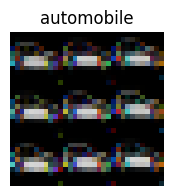

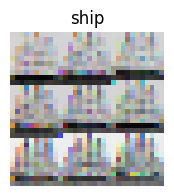

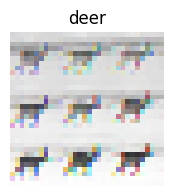

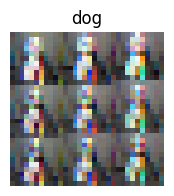

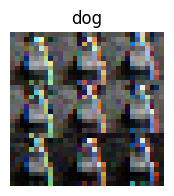

In [ ]:

# Define a dictionary to map the numeric labels to their corresponding class names
class_names = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

# Select a random sample of images to display
num_samples = 5
random_indices = np.random.choice(len(x_train), num_samples)

# Display the images and their corresponding labels
for i in range(num_samples):
    image = x_train[random_indices[i]]
    label = y_train[random_indices[i]]

    # Convert the one-hot encoded label to a numeric class label
    class_label = np.argmax(label)

    # Plot the image
    plt.figure(figsize=(2, 2))
    plt.imshow(image)
    plt.axis('off')

    # Set the title as the corresponding class name
    plt.title(class_names[class_label])

    # Show the plot
    plt.show()
